In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from io import StringIO

# Import API key
import config
from config import api_key


# Create dataframes from csv files
df_2017 = pd.read_csv("Data/PrescribingRate2017.csv", encoding="ISO-8859-1")
df_2016 = pd.read_csv("Data/PrescribingRate2016.csv", encoding="ISO-8859-1")
df_2015 = pd.read_csv("Data/PrescribingRate2015.csv", encoding="ISO-8859-1")
df_2014 = pd.read_csv("Data/PrescribingRate2014.csv", encoding="ISO-8859-1")
df_2013 = pd.read_csv("Data/PrescribingRate2013.csv", encoding="ISO-8859-1")
df_2012 = pd.read_csv("Data/PrescribingRate2012.csv", encoding="ISO-8859-1")
df_2011 = pd.read_csv("Data/PrescribingRate2011.csv", encoding="ISO-8859-1")
df_2010 = pd.read_csv("Data/PrescribingRate2010.csv", encoding="ISO-8859-1")
df_2009 = pd.read_csv("Data/PrescribingRate2009.csv", encoding="ISO-8859-1")
df_2008 = pd.read_csv("Data/PrescribingRate2008.csv", encoding="ISO-8859-1")
df_2007 = pd.read_csv("Data/PrescribingRate2007.csv", encoding="ISO-8859-1")
df_2006 = pd.read_csv("Data/PrescribingRate2006.csv", encoding="ISO-8859-1")
df_uszips = pd.read_csv("Data/uszips.csv", encoding="ISO-8859-1",converters={'zip': '{:0>5}'.format}) #this format adds zeros to zip if >5 digits
df_deaths = pd.read_csv("Data/CDC_Data.csv", encoding="ISO-8859-1")

#-----------------------------------------------------#
#------------Data Munging/Cleaning/Merging------------#
#-----------------------------------------------------#

# First check that files being merged have same column header names
list(df_2017) == list(df_2016)
list(df_2017)

['Year',
 'County',
 'State',
 'State/County FIPS Code',
 'Opioid Prescribing Rate per 100']

In [2]:
# Rename columns of 2017 dataframe to match for merge
columns_renamed = {'Year': 'Year',
 'County': 'County',
 'State': 'State',
 'State/County FIPS Code': 'FIPS County Code',
 'Opioid Prescribing Rate per 100': 'Opioid Prescribing Rate per 100'}

df_2017 = df_2017.rename(columns=columns_renamed)
list(df_2017)

['Year',
 'County',
 'State',
 'FIPS County Code',
 'Opioid Prescribing Rate per 100']

In [3]:
# Check that column names across all dataframes are uniform
list(df_2017) == list(df_2016) == list(df_2015) == list(df_2014) == list(df_2013) == list(df_2012) == list(df_2011) == list(df_2010) \
== list(df_2009) == list(df_2008) == list(df_2007) == list(df_2006)

True

In [4]:
# Since column names are all the same, we can use concatinate to merge all files
merged_df = pd.concat([df_2017, df_2016, df_2015, df_2014, df_2013, df_2012, df_2011, df_2010, \
                      df_2009, df_2008, df_2007, df_2006])

In [5]:
merged_df.count()

Year                               37542
County                             37542
State                              37542
FIPS County Code                   37542
Opioid Prescribing Rate per 100    37528
dtype: int64

In [6]:
# Create Groupby Dataframes
# grouped_countycode = merged_df.groupby(['FIPS County Code'])
# grouped_countycode_year = merged_df.groupby(['Year','FIPS County Code'])
# grouped_countycode_year.count()

In [7]:
# Clean uszips data, and combine it with merged df to create df with both FIPS and ZIP

df_uszips.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,all_county_weights,imprecise,military,timezone
0,00951,18.4284,-66.2566,Toa Baja,PR,Puerto Rico,True,NaN,35,32.5,72137,Toa Baja,{'72137':100},False,False,America/Puerto_Rico
1,96863,21.4484,-157.7623,Mcbh Kaneohe Bay,HI,Hawaii,True,NaN,52,708.1,15003,Honolulu,{'15003':100},False,False,Pacific/Honolulu
2,34141,25.9723,-81.0936,Ochopee,FL,Florida,True,NaN,232,0.1,12021,Collier,"{'12021':97.41,'12087':2.59}",False,False,America/New_York
3,78060,28.4469,-98.1071,Oakville,TX,Texas,True,NaN,37,36.3,48297,Live Oak,{'48297':100},False,False,America/Chicago
4,78144,28.9551,-97.8880,Panna Maria,TX,Texas,True,NaN,45,7.7,48255,Karnes,{'48255':100},False,False,America/Chicago


In [8]:
# Create dataframe with only variables we want to use
df_uszips_clean = df_uszips[['zip','city','county_fips','county_name']]
df_uszips_clean.head()

,zip,city,county_fips,county_name
0,00951,Toa Baja,72137,Toa Baja
1,96863,Mcbh Kaneohe Bay,15003,Honolulu
2,34141,Ochopee,12021,Collier
3,78060,Oakville,48297,Live Oak
4,78144,Panna Maria,48255,Karnes


In [9]:
list(merged_df)

['Year',
 'County',
 'State',
 'FIPS County Code',
 'Opioid Prescribing Rate per 100']

In [10]:
# Change column names to match with the merged data on the column we want to merge with
columns_renamed = {'zip': 'Zip Code',
 'city': 'City',
 'county_fips': 'FIPS County Code',
 'county_name': 'County Name'}

df_uszips_clean = df_uszips_clean.rename(columns=columns_renamed)
list(df_uszips_clean)

['Zip Code', 'City', 'FIPS County Code', 'County Name']

In [11]:
# Now merge the Zip Code data with the Merged prescription rate dataframe
zip_merged = pd.merge(merged_df, df_uszips_clean, on="FIPS County Code")
zip_merged.head()

,Year,County,State,FIPS County Code,Opioid Prescribing Rate per 100,Zip Code,City,County Name
0,2017,AUTAUGA,AL,1001,106.6,36006,Billingsley,Autauga
1,2017,AUTAUGA,AL,1001,106.6,36003,Autaugaville,Autauga
2,2017,AUTAUGA,AL,1001,106.6,36091,Verbena,Autauga
3,2017,AUTAUGA,AL,1001,106.6,36067,Prattville,Autauga
4,2017,AUTAUGA,AL,1001,106.6,36051,Marbury,Autauga


In [12]:
zip_merged["Opioid Prescribing Rate per 100"]

0         106.6
1         106.6
2         106.6
3         106.6
4         106.6
5         106.6
6         106.6
7         129.6
8         129.6
9         129.6
10        129.6
11        129.6
12        129.6
13        129.6
14        129.9
15        129.9
16        129.9
17        129.9
18        129.9
19        129.9
20        129.9
21        145.3
22        145.3
23        145.3
24        145.3
25        145.3
26        145.3
27        145.3
28        166.7
29        166.7
          ...  
394887        
394888        
394889        
394890        
394891        
394892        
394893        
394894        
394895        Ð
394896        Ð
394897        
394898        
394899        
394900        
394901        
394902        
394903        
394904        
394905        ?
394906        ?
394907        
394908        
394909        
394910        
394911        
394912        
394913        
394914        
394915        
394916        
Name: Opioid Prescribing

In [13]:
# Now check for missing data and drop rows
zip_merged.count()

Year                               394917
County                             394917
State                              394917
FIPS County Code                   394917
Opioid Prescribing Rate per 100    394838
Zip Code                           394917
City                               394917
County Name                        394917
dtype: int64

In [14]:
zip_merged = zip_merged.dropna(how='any')

In [15]:
zip_merged.count()

Year                               394838
County                             394838
State                              394838
FIPS County Code                   394838
Opioid Prescribing Rate per 100    394838
Zip Code                           394838
City                               394838
County Name                        394838
dtype: int64

In [16]:
# Sort by each column to check first and last data from each column

zip_merged.sort_values("Year", ascending=False)
zip_merged.sort_values("Year", ascending=True)

zip_merged.sort_values("County", ascending=False)
zip_merged.sort_values("County", ascending=True)

zip_merged.sort_values("State", ascending=False)
zip_merged.sort_values("State", ascending=True)

zip_merged.sort_values("FIPS County Code", ascending=False)
zip_merged.sort_values("FIPS County Code", ascending=True)

# When sorting this column, we can see that there are strings/ non-numeric values, by getting an error
#........zip_merged.sort_values("Opioid Prescribing Rater per 100", ascending=False)
# Drop all rows from Opioid column that are non-integers

zip_merged["Opioid Prescribing Rate per 100"] = pd.to_numeric(zip_merged["Opioid Prescribing Rate per 100"], errors='coerce')
zip_merged["Opioid Prescribing Rate per 100"].value_counts()
new_zip_merged = zip_merged.dropna()
new_zip_merged.info()

new_zip_merged.sort_values("Opioid Prescribing Rate per 100", ascending=True)
new_zip_merged.sort_values("Opioid Prescribing Rate per 100", ascending=True)

new_zip_merged.sort_values("Zip Code", ascending=False)
new_zip_merged.sort_values("Zip Code", ascending=True)

new_zip_merged.sort_values("City", ascending=False)
new_zip_merged.sort_values("City", ascending=True)

new_zip_merged.sort_values("County Name", ascending=False)
new_zip_merged.sort_values("County Name", ascending=True)

# Double check new count of rows from cleaned dataframe
new_zip_merged.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378478 entries, 0 to 394686
Data columns (total 8 columns):
Year                               378478 non-null int64
County                             378478 non-null object
State                              378478 non-null object
FIPS County Code                   378478 non-null int64
Opioid Prescribing Rate per 100    378478 non-null float64
Zip Code                           378478 non-null object
City                               378478 non-null object
County Name                        378478 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 26.0+ MB


Year                               378478
County                             378478
State                              378478
FIPS County Code                   378478
Opioid Prescribing Rate per 100    378478
Zip Code                           378478
City                               378478
County Name                        378478
dtype: int64

In [17]:
#--------------------------------------------------------#
#------------Create Graphs from combined data------------#
#--------------------------------------------------------#

# First, want to look at total prescription rates by YEAR
year_opioid_df = new_zip_merged[['Year','Opioid Prescribing Rate per 100']]
year_opioid_df.count()

grouped_year = year_opioid_df.groupby(['Year'])
grouped_year.sum()

,Opioid Prescribing Rate per 100
Year,
2006,2404203.1
2007,2522713.3
2008,2614012.1
2009,2661189.7
2010,2723461.2
2011,2723240.8
2012,2782169.4
2013,2696348.8
2014,2634467.0


In [37]:
# Create x and y variables
year = grouped_year['Year'].unique()
rx_rate = grouped_year['Opioid Prescribing Rate per 100'].sum()/10000

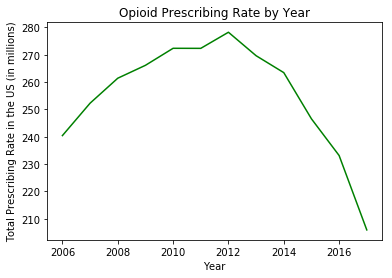

<Figure size 432x288 with 0 Axes>

In [38]:
# Plot the graph
plt.plot(year, rx_rate, color='g')
# OVERLAY SECOND LINE GRAPH:
#plt.plot(x, y, color='orange')
plt.xlabel('Year')
plt.ylabel('Total Prescribing Rate in the US (in millions)')
plt.title('Opioid Prescribing Rate by Year')
plt.show()
plt.savefig("Images/OpioidPrescriptionsByYear.png")

In [20]:
df_deaths.head()

,Zipcode,County,Deaths,Population,Crude Rate,% of Total Deaths
0,1003,"Baldwin County, AL",19,212628,Unreliable,0.00%
1,1043,"Cullman County, AL",12,82755,Unreliable,0.00%
2,1049,"DeKalb County, AL",11,71617,Unreliable,0.00%
3,1055,"Etowah County, AL",26,102755,25.3,0.10%
4,1073,"Jefferson County, AL",167,659197,25.3,0.40%


In [21]:
zip_merged.sort_values("FIPS County Code", ascending=True)
#zip_merged.sort_values("FIPS County Code", ascending=True)

,Year,County,State,FIPS County Code,Opioid Prescribing Rate per 100,Zip Code,City,County Name
0,2017,AUTAUGA,AL,1001,106.6,36006,Billingsley,Autauga
60,2009,"Autauga, AL",AL,1001,147.5,36051,Marbury,Autauga
59,2009,"Autauga, AL",AL,1001,147.5,36067,Prattville,Autauga
58,2009,"Autauga, AL",AL,1001,147.5,36091,Verbena,Autauga
57,2009,"Autauga, AL",AL,1001,147.5,36003,Autaugaville,Autauga
56,2009,"Autauga, AL",AL,1001,147.5,36006,Billingsley,Autauga
55,2010,"Autauga, AL",AL,1001,151.7,36749,Jones,Autauga
54,2010,"Autauga, AL",AL,1001,151.7,36066,Prattville,Autauga
53,2010,"Autauga, AL",AL,1001,151.7,36051,Marbury,Autauga
52,2010,"Autauga, AL",AL,1001,151.7,36067,Prattville,Autauga


In [36]:
new_2017_df = new_zip_merged[new_zip_merged["Year"] == 2017]

new_2017_df.to_csv("Data/new_2017_df.csv", encoding="utf-8", index=False)

In [27]:
type(new_zip_merged)

pandas.core.frame.DataFrame